In [1]:
import warnings
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import ast
import shap
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/MultiLabelSongs_RO_prepared_preprocessed.csv")
df['labels'] = df['labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
df['labels'] = df['labels'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
df['labels'] = df['labels'].str.split(',\s*')
df

,artist,genre,title,album,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,vrea deranja vrea promi vrea vrea deranja vrea...,"[Calmness, Sadness]"
1,Damian Marley,Reggae,Here We Go,Stony Hill,merge ego mare gon na problemă juca erou putea...,"[Power, Tension]"
2,The Mission UK,Rock,Jade,Another Fall from Grace,vedet aluzie univers abilita cuvânt cicatric s...,"[Amazement, Calmness, Solemnity, Tenderness]"
3,UB40,Reggae,Food For Thought,Signing Off,dying dust West bosom empty skies creepinge kn...,"[Joyful activation, Sadness, Tension]"
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,toting pack dusty winnemucca road alonge sem h...,"[Amazement, Calmness, Joyful activation]"
...,...,...,...,...,...,...
1105,Run-D.M.C.,Hip-Hop,King of Rock,King of Rock,rege nici_un fraier trebui sune sire arde treb...,"[Joyful activation, Power]"
1106,The Beatles,Rock,Yesterday,Help!,troublede seemed far away looks though stay be...,"[Nostalgia, Sadness, Tenderness]"
1107,The Sundays,Rock,Love,Blind,pictur thin white child Back day born slapped ...,"[Calmness, Power, Tenderness]"
1108,The Cure,Rock,Killing an Arab,Boys Don’t Cry,standing beach Gun hand staring sea staringe s...,"[Power, Solemnity, Tension]"


In [3]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['labels'])

for i, label in enumerate(mlb.classes_):
    print(f"{i}: {label}")

0: Amazement
1: Calmness
2: Joyful activation
3: Nostalgia
4: Power
5: Sadness
6: Solemnity
7: Tenderness
8: Tension


In [11]:
tfidf = TfidfVectorizer(max_features=300, ngram_range=(1, 1))
X = tfidf.fit_transform(df['lyrics'].fillna(''))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
def performance(y_pred):
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f"Micro F1-score: {f1_micro:.4f}")
    print(f"Macro F1-score: {f1_macro:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=mlb.classes_))

In [7]:
def train_evaluate(model):
    clf = OneVsRestClassifier(model)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    performance(y_pred)

## Logistic Regression - F1 micro 44% - F1 macro 34%

In [10]:
train_evaluate(LogisticRegression(max_iter=10000))

Micro F1-score: 0.4399
Macro F1-score: 0.3392

Classification Report:
                   precision    recall  f1-score   support

        Amazement       0.00      0.00      0.00        47
         Calmness       1.00      0.06      0.11        53
Joyful activation       0.67      0.08      0.15        71
        Nostalgia       0.46      0.19      0.27        88
            Power       0.86      0.42      0.56       103
          Sadness       0.62      0.65      0.64       107
        Solemnity       0.60      0.12      0.20        74
       Tenderness       0.74      0.48      0.58       100
          Tension       0.60      0.49      0.54       108

        micro avg       0.65      0.33      0.44       751
        macro avg       0.62      0.28      0.34       751
     weighted avg       0.64      0.33      0.40       751
      samples avg       0.61      0.35      0.43       751




SHAP for class: Amazement


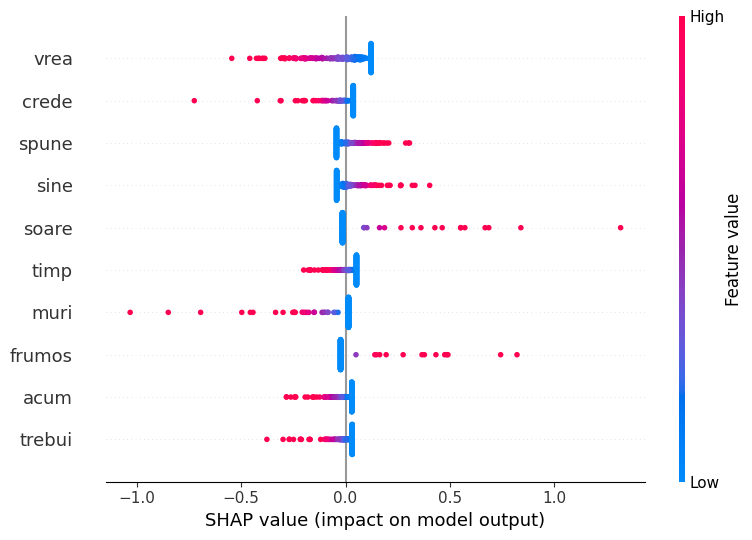


SHAP for class: Calmness


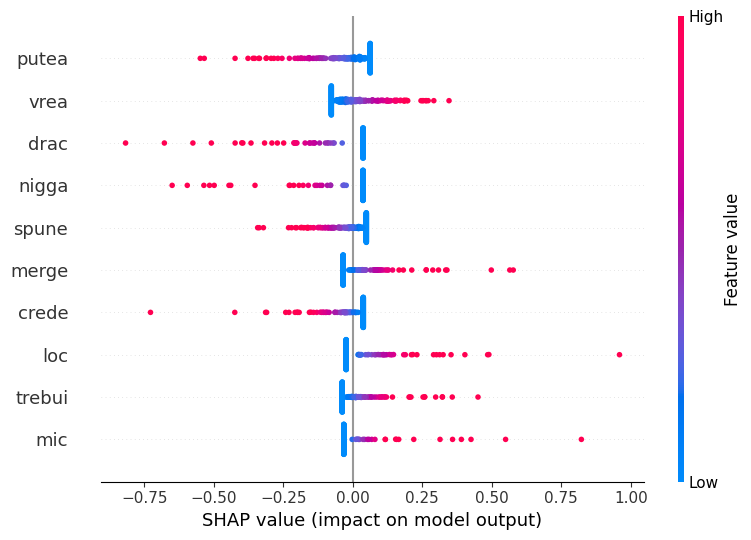


SHAP for class: Joyful activation


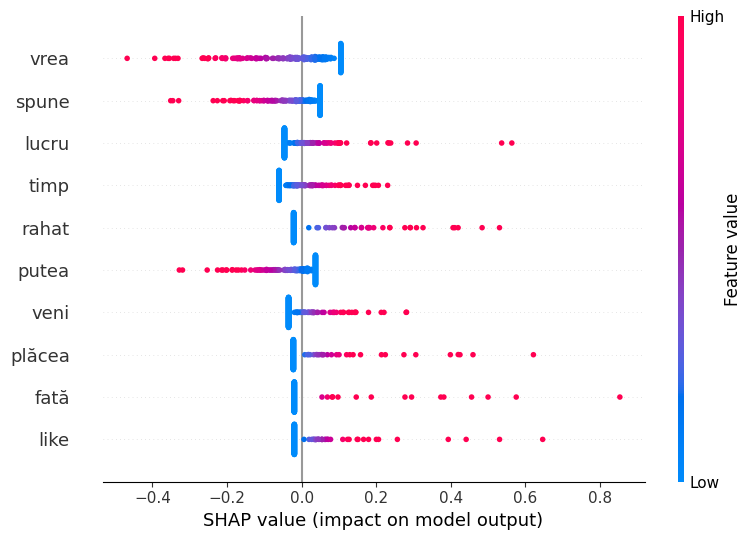


SHAP for class: Nostalgia


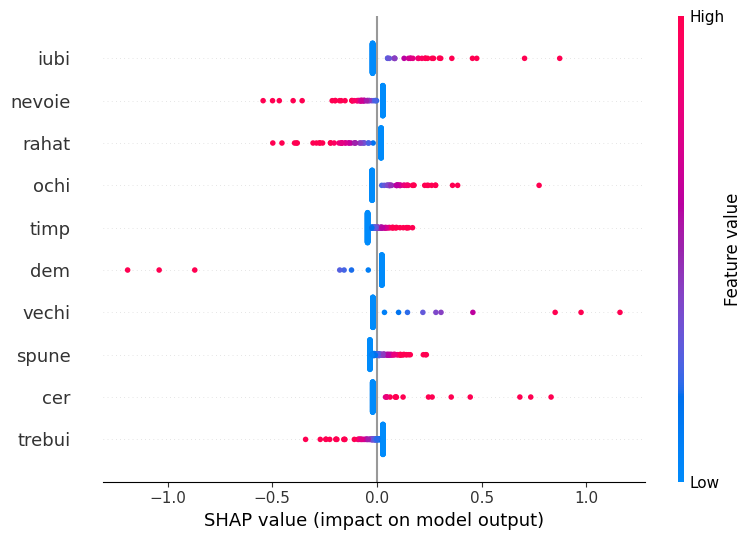


SHAP for class: Power


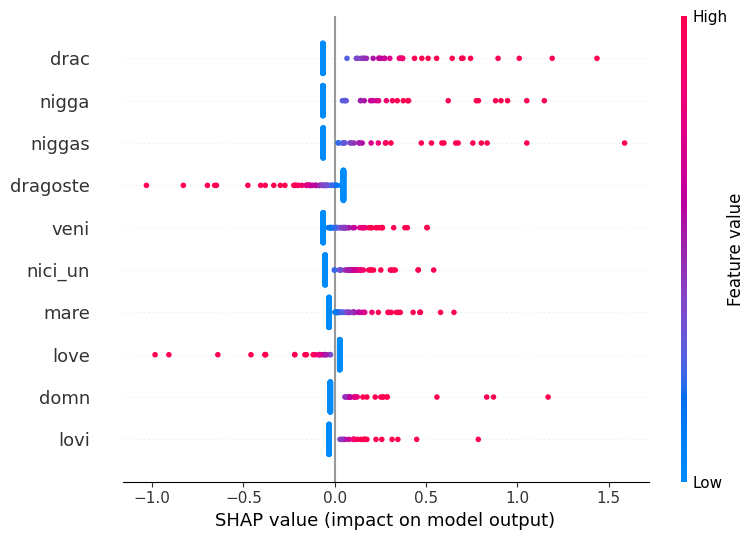


SHAP for class: Sadness


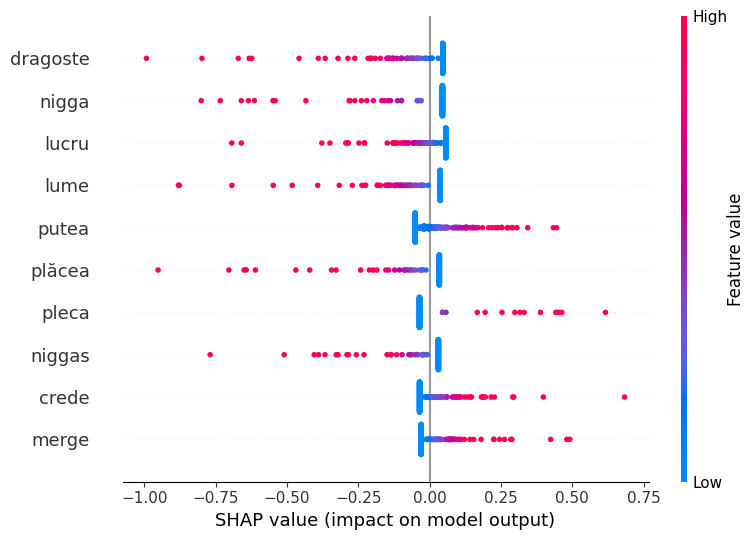


SHAP for class: Solemnity


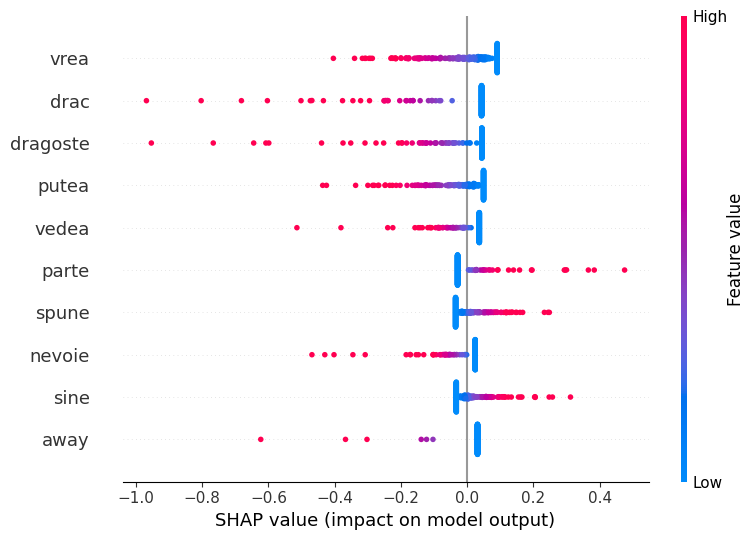


SHAP for class: Tenderness


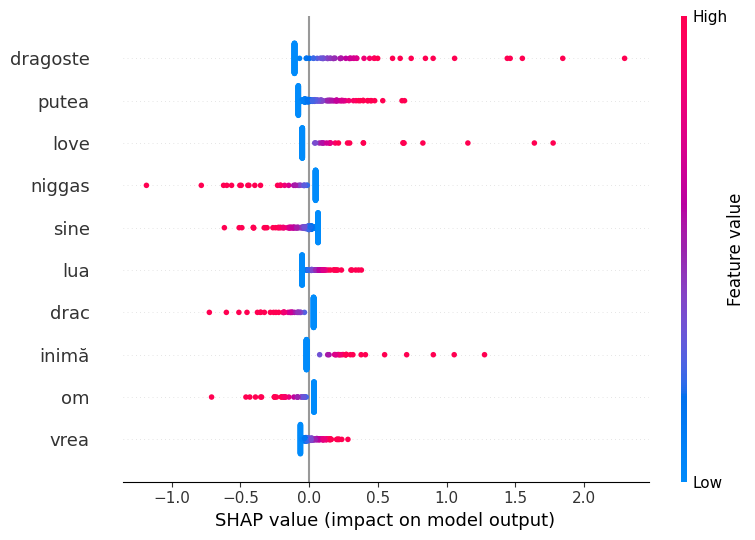


SHAP for class: Tension


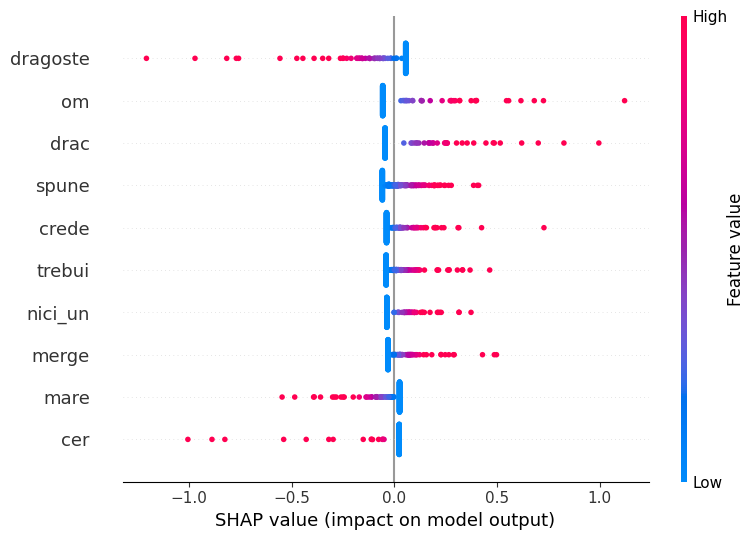

In [67]:
clf = OneVsRestClassifier(LogisticRegression(max_iter=10000))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

import numpy as np

feature_names = tfidf.get_feature_names_out()
X_sample = X_test.toarray()
X_train_sample = X_train.toarray()

for i, label in enumerate(mlb.classes_):
    print(f"\nSHAP for class: {label}")
    classifier = clf.estimators_[i]
    explainer = shap.LinearExplainer(classifier, X_train_sample)
    shap_values = explainer(X_sample)
    mean_abs_shap = np.mean(np.abs(shap_values.values), axis=0)
    top_indices = np.argsort(mean_abs_shap)[::-1][:10]
    shap_values_top = shap_values.values[:, top_indices]
    X_sample_top = X_sample[:, top_indices]
    feature_names_top = feature_names[top_indices]

    shap_exp = shap.Explanation(values=shap_values_top,
                                data=X_sample_top,
                                feature_names=feature_names_top)

    shap.summary_plot(shap_exp, show=True)


## Random Forest - F1 micro 44.3% - F1 macro 34.2%


In [8]:
train_evaluate(RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=42))

Micro F1-score: 0.4429
Macro F1-score: 0.3421

Classification Report:
                   precision    recall  f1-score   support

        Amazement       0.00      0.00      0.00        47
         Calmness       0.50      0.06      0.10        53
Joyful activation       0.64      0.10      0.17        71
        Nostalgia       0.50      0.22      0.30        88
            Power       0.90      0.43      0.58       103
          Sadness       0.61      0.64      0.62       107
        Solemnity       0.57      0.11      0.18        74
       Tenderness       0.66      0.49      0.56       100
          Tension       0.60      0.52      0.56       108

        micro avg       0.64      0.34      0.44       751
        macro avg       0.55      0.28      0.34       751
     weighted avg       0.60      0.34      0.40       751
      samples avg       0.61      0.36      0.43       751



## Linear SVC - F1 micro 48% - F1 macro 44%

In [28]:
train_evaluate(LinearSVC(random_state=42, max_iter=10000, C=1.0))

Micro F1-score: 0.4815
Macro F1-score: 0.4356

Classification Report:
                   precision    recall  f1-score   support

        Amazement       0.17      0.11      0.13        47
         Calmness       0.41      0.25      0.31        53
Joyful activation       0.50      0.32      0.39        71
        Nostalgia       0.46      0.35      0.40        88
            Power       0.69      0.48      0.56       103
          Sadness       0.59      0.55      0.57       107
        Solemnity       0.53      0.28      0.37        74
       Tenderness       0.66      0.52      0.58       100
          Tension       0.61      0.61      0.61       108

        micro avg       0.56      0.42      0.48       751
        macro avg       0.51      0.39      0.44       751
     weighted avg       0.55      0.42      0.47       751
      samples avg       0.55      0.44      0.47       751




SHAP for class: Amazement


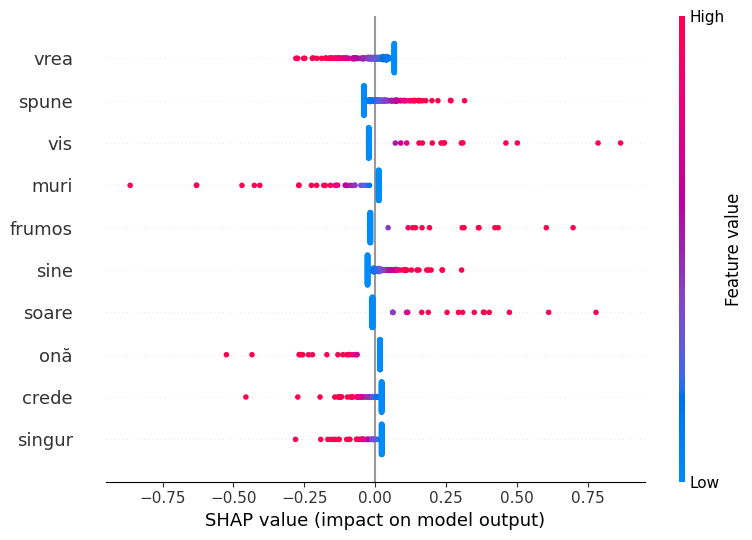


SHAP for class: Calmness


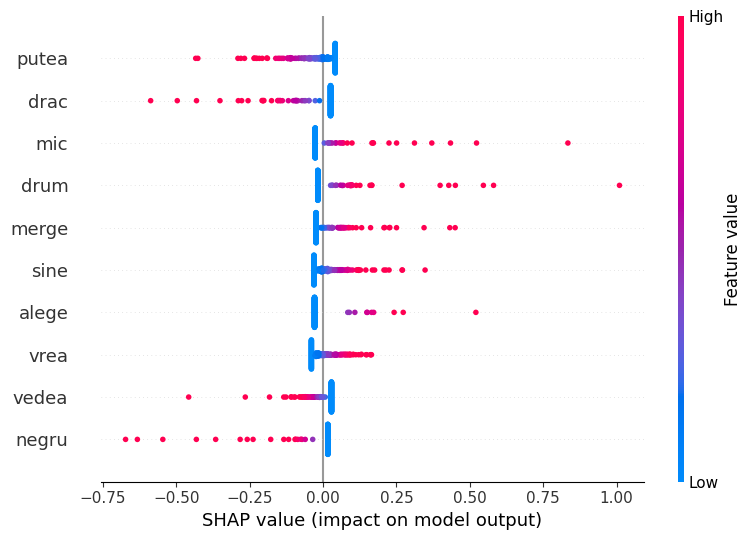


SHAP for class: Joyful activation


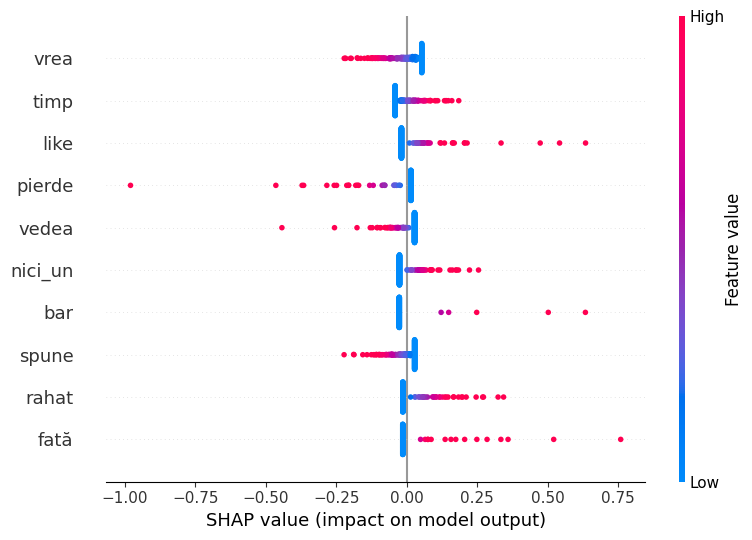


SHAP for class: Nostalgia


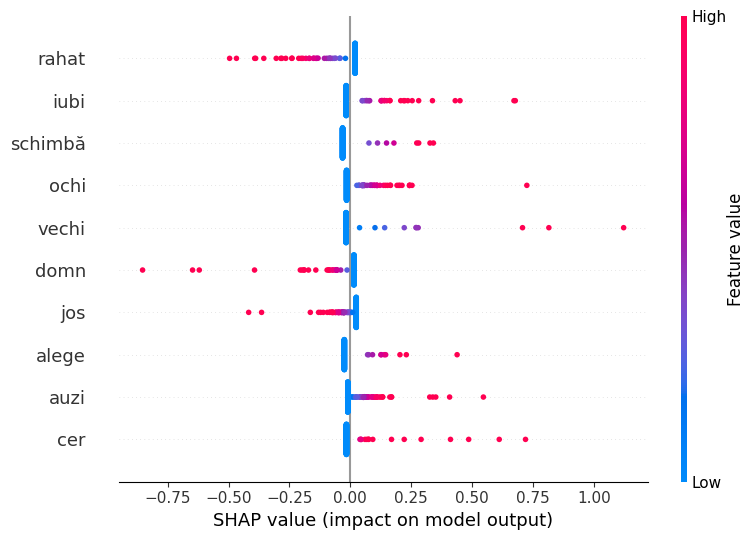


SHAP for class: Power


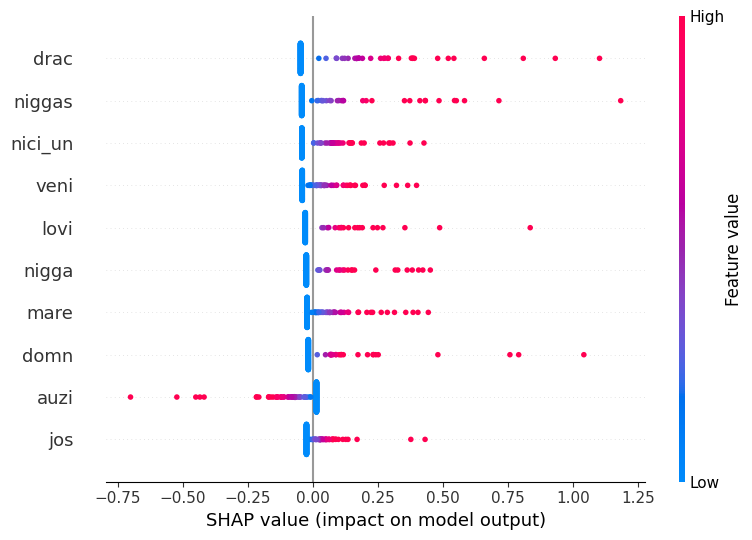


SHAP for class: Sadness


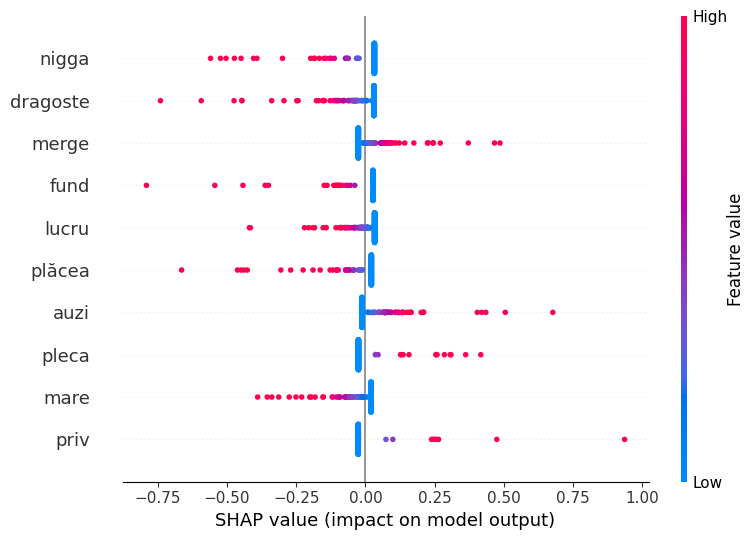


SHAP for class: Solemnity


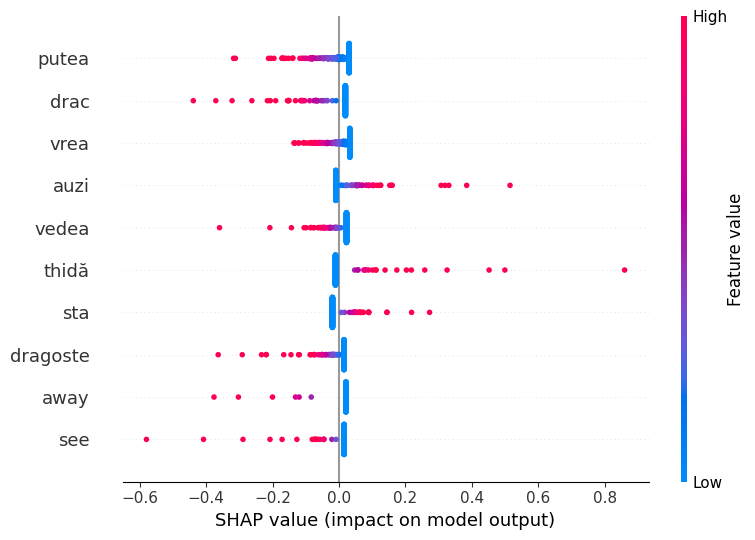


SHAP for class: Tenderness


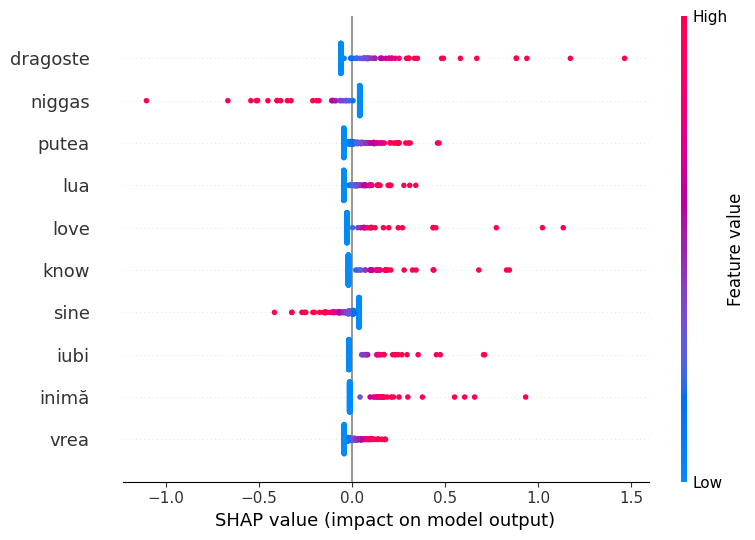


SHAP for class: Tension


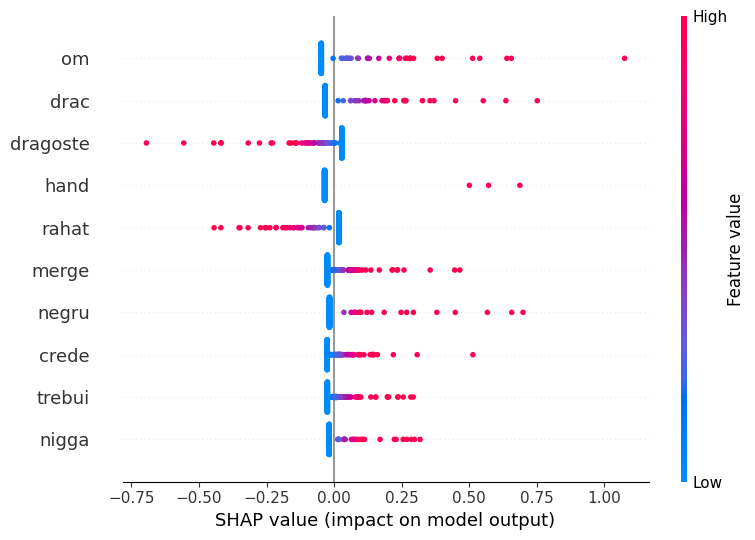

In [31]:
import numpy as np
clf = OneVsRestClassifier(LinearSVC(random_state=42, max_iter=10000, C=1.0))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

feature_names = tfidf.get_feature_names_out()
X_sample = X_test.toarray()
X_train_sample = X_train.toarray()

for i, label in enumerate(mlb.classes_):
    print(f"\nSHAP for class: {label}")
    classifier = clf.estimators_[i]
    explainer = shap.LinearExplainer(classifier, X_train_sample)
    shap_values = explainer(X_sample)
    mean_abs_shap = np.mean(np.abs(shap_values.values), axis=0)
    top_indices = np.argsort(mean_abs_shap)[::-1][:10]
    shap_values_top = shap_values.values[:, top_indices]
    X_sample_top = X_sample[:, top_indices]
    feature_names_top = feature_names[top_indices]

    shap_exp = shap.Explanation(values=shap_values_top,
                                data=X_sample_top,
                                feature_names=feature_names_top)

    shap.summary_plot(shap_exp, show=True)


## K-Neighbors - F1 micro 45.6% - F1 macro 40.3%

In [9]:
train_evaluate(KNeighborsClassifier(n_neighbors=3))

Micro F1-score: 0.4563
Macro F1-score: 0.4033

Classification Report:
                   precision    recall  f1-score   support

        Amazement       0.24      0.13      0.17        47
         Calmness       0.20      0.13      0.16        53
Joyful activation       0.36      0.24      0.29        71
        Nostalgia       0.43      0.34      0.38        88
            Power       0.66      0.50      0.57       103
          Sadness       0.55      0.55      0.55       107
        Solemnity       0.41      0.28      0.34        74
       Tenderness       0.67      0.58      0.62       100
          Tension       0.55      0.56      0.56       108

        micro avg       0.51      0.41      0.46       751
        macro avg       0.45      0.37      0.40       751
     weighted avg       0.49      0.41      0.45       751
      samples avg       0.51      0.43      0.44       751



## XGBClassifier - F1 micro 47% - F1 macro 41.5%

In [13]:
train_evaluate(XGBClassifier(use_label_encoder=False, eval_metric='logloss'))

Micro F1-score: 0.4698
Macro F1-score: 0.4149

Classification Report:
                   precision    recall  f1-score   support

        Amazement       0.38      0.13      0.19        47
         Calmness       0.43      0.11      0.18        53
Joyful activation       0.54      0.27      0.36        71
        Nostalgia       0.48      0.33      0.39        88
            Power       0.75      0.52      0.62       103
          Sadness       0.57      0.52      0.55       107
        Solemnity       0.49      0.26      0.34        74
       Tenderness       0.64      0.58      0.61       100
          Tension       0.54      0.48      0.51       108

        micro avg       0.57      0.40      0.47       751
        macro avg       0.53      0.36      0.41       751
     weighted avg       0.56      0.40      0.45       751
      samples avg       0.56      0.42      0.45       751



## MLPClassifier - F1 micro 48% - F1 macro 43%

In [80]:
train_evaluate(MLPClassifier(hidden_layer_sizes=(300,), max_iter=500, random_state=42))

Micro F1-score: 0.4809
Macro F1-score: 0.4307

Classification Report:
                   precision    recall  f1-score   support

        Amazement       0.22      0.13      0.16        47
         Calmness       0.30      0.19      0.23        53
Joyful activation       0.49      0.27      0.35        71
        Nostalgia       0.44      0.36      0.40        88
            Power       0.68      0.50      0.58       103
          Sadness       0.57      0.58      0.58       107
        Solemnity       0.41      0.34      0.37        74
       Tenderness       0.66      0.63      0.65       100
          Tension       0.59      0.55      0.57       108

        micro avg       0.54      0.44      0.48       751
        macro avg       0.48      0.39      0.43       751
     weighted avg       0.52      0.44      0.47       751
      samples avg       0.55      0.45      0.47       751

